In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set(rc={'figure.figsize': (12, 9)})

In [2]:
events_data = pd.read_csv('event_data_train.zip')
submissions_data = pd.read_csv('submissions_data_train.zip')

FileNotFoundError: [Errno 2] No such file or directory: 'event_data_train.zip'

In [91]:
events_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [92]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [93]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [94]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [95]:
events_data['day'] = events_data.date.dt.date
events_data.head(10)

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
5,32811,1434340895,passed,17632,2015-06-15 04:01:35,2015-06-15
6,32929,1434340921,discovered,17632,2015-06-15 04:02:01,2015-06-15
7,32929,1434340921,viewed,17632,2015-06-15 04:02:01,2015-06-15
8,32929,1434340939,started_attempt,17632,2015-06-15 04:02:19,2015-06-15
9,32929,1434340944,passed,17632,2015-06-15 04:02:24,2015-06-15


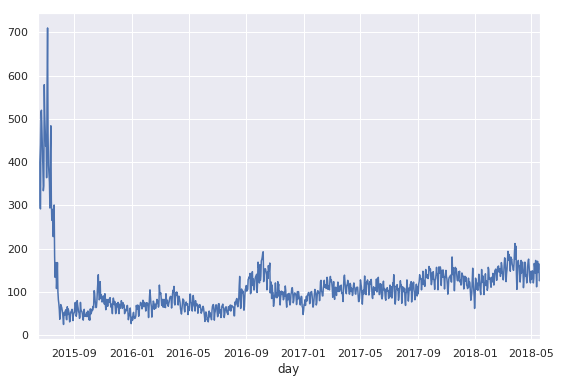

In [96]:
events_data.groupby('day').user_id.nunique().plot()

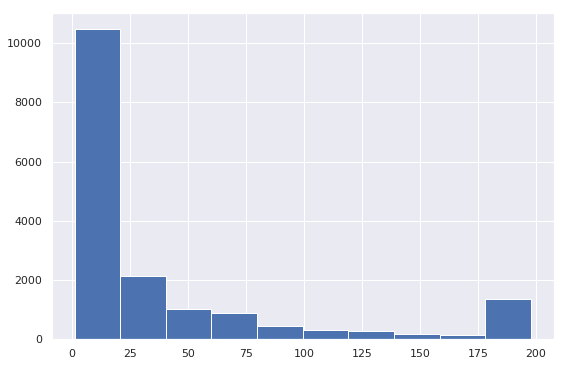

In [97]:
# wrong action, does not represent users with 0 passed steps
events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index = False) \
    .agg({'step_id': 'count'}) \
    .rename(columns={'step_id': 'passed_steps'}).passed_steps.hist()

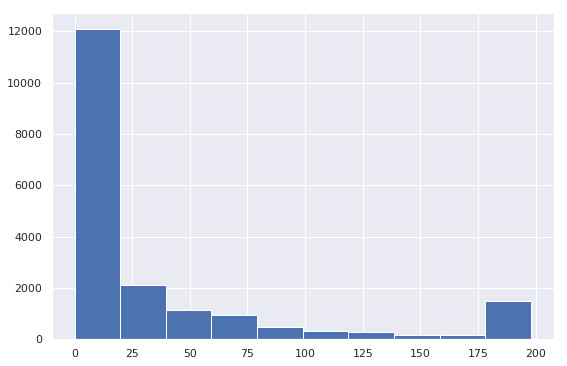

In [98]:
events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index().discovered.hist()

In [99]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head(10)

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
5,31976,1434348188,correct,15853,2015-06-15 06:03:08,2015-06-15
6,31976,1478852055,correct,15853,2016-11-11 08:14:15,2016-11-11
7,31977,1434347371,correct,15853,2015-06-15 05:49:31,2015-06-15
8,31978,1434349981,correct,15853,2015-06-15 06:33:01,2015-06-15
9,31979,1434446091,correct,15853,2015-06-16 09:14:51,2015-06-16


In [100]:
users_scores = submissions_data.pivot_table(index='user_id',
                                            columns='submission_status',
                                            values='step_id',
                                            aggfunc='count',
                                            fill_value=0).reset_index()
users_scores.head(10)

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
5,16,77,106
6,17,0,2
7,22,76,47
8,25,1,4
9,26,7,16


In [101]:
gaps_data = events_data[['user_id', 'timestamp', 'day']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values
gaps_data = pd.Series(np.concatenate(gaps_data, axis=0))
gaps_data.quantile(0.9) / (24 * 60 * 60)

18.325995370370403

In [102]:
# task: to find secret id
events_data[events_data.action == 'started_attempt'].groupby('user_id') \
    .action.count().sort_values(ascending=False).head(10)

user_id
1046     721
3572     550
8394     337
6662     285
1649     281
7702     276
5454     265
5096     232
21602    227
5552     224
Name: action, dtype: int64

In [103]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})
now = 1526882911
drop_out_threshold = 2592000
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [104]:
users_scores.head()
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data.fillna(0)
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [107]:
users_events_data = events_data.pivot_table(index='user_id',
                                           columns='action',
                                           values='step_id',
                                           aggfunc='count',
                                           fill_value=0).reset_index()
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [108]:
users_data = users_data.merge(users_events_data, how='outer')

In [110]:
users_data = users_data.fillna(0)
users_data.head(10)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1
5,8,1481466913,True,9.0,21.0,109,84,37,156
6,9,1484999497,True,0.0,0.0,3,3,0,4
7,11,1526140625,False,0.0,0.0,1,0,1,1
8,14,1436368676,True,0.0,1.0,4,3,1,9
9,16,1513162585,True,77.0,106.0,196,196,108,651


In [112]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_days

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1
5,8,2
6,9,1
7,11,1
8,14,1
9,16,21


In [113]:
users_data = users_data.merge(users_days, how='outer')

In [114]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [116]:
users_data.user_id.nunique() == events_data.user_id.nunique()

True

In [118]:
users_data['passed_course'] = users_data.passed > 170
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425
